https://medium.com/grabngoinfo/hyperparameter-tuning-and-regularization-for-time-series-model-using-prophet-in-python-9791370a07dc

Import libraries

In [1]:
import pandas as pd
from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

/home/samuell/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Load dataset and prepare df

In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date_reported"
target_column = "New_deaths"
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column]]

df.set_index(date_column, inplace=True)
df = df.groupby(date_column).sum().reset_index()

df = df.dropna()
df.rename(columns={date_column: 'ds', target_column: 'y'}, inplace=True)
df['floor'] = 0
dates = df['ds'].values

Train test split

In [3]:
data_length = len(df)
train_split = 0.9
train = df.iloc[:int(data_length*train_split)]
test = df.iloc[int(data_length*train_split):]

Parameter tuning for order

In [4]:
# Initiate the model
baseline_model = Prophet()# Fit the model on the training dataset
baseline_model.fit(train)

14:58:05 - cmdstanpy - INFO - Chain [1] start processing
14:58:05 - cmdstanpy - INFO - Chain [1] done processing


Create Model

In [5]:
baseline_model_cv = cross_validation(model=baseline_model, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")
baseline_model_cv.head()

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:58:06 - cmdstanpy - INFO - Chain [1] start processing
14:58:06 - cmdstanpy - INFO - Chain [1] start processing
14:58:06 - cmdstanpy - INFO - Chain [1] start processing
14:58:06 - cmdstanpy - INFO - Chain [1] start processing
14:58:06 - cmdstanpy - INFO - Chain [1] start processing
14:58:06 - cmdstanpy - INFO - Chain [1] done processing
14:58:06 - cmdstanpy - INFO - Chain [1] start processing
14:58:06 - cmdstanpy - INFO - Chain [1] start processing
14:58:06 - cmdstanpy - INFO - Chain [1] done processing
14:58:06 - cmdstanpy - INFO - Chain [1] done processing
14:58:06 - cmdstanpy - INFO - Chain [1] done processing
14:58:06 - cmdstanpy - INFO - Chain [1] start processing
14:58:06 - cmdstanpy - INFO - Chain [1] start processing
14:58:06 - cmdstanpy - INFO - Chain [1] done processing
14:58:06 - cmdstanpy - INFO - Chain [1] start processing
14:58:06 - cmdstanpy - INFO - Chain [1] start 

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-01-15,13575.205915,11146.440545,16047.774781,13976,2021-01-14
1,2021-01-16,13528.583886,11086.950939,16116.157409,13501,2021-01-14
2,2021-01-17,17707.497505,15338.851806,20088.363886,26969,2021-01-14
3,2021-01-18,12933.158250,10077.023221,15446.089867,12295,2021-01-14
4,2021-01-19,12592.543288,9950.430371,15089.503616,11463,2021-01-14


Plot the result

In [6]:
# Model performance metrics
baseline_model_p = performance_metrics(baseline_model_cv, rolling_window=1)
baseline_model_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,9.646013e+06,3105.803113,2483.110555,1.155424,0.525985,0.776565,0.595556


RMSE of the result

In [7]:
# Get the performance metric value
baseline_model_p['mape'].values[0]

1.155423804860344

In [8]:
# Initiate the model
manual_model = Prophet(changepoint_range=0.9)# Fit the model on the training dataset
manual_model.fit(train)# Cross validation
manual_model_cv = cross_validation(manual_model, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")# Model performance metrics
manual_model_p = performance_metrics(manual_model_cv, rolling_window=1)
manual_model_p['mape'].values[0]

14:58:07 - cmdstanpy - INFO - Chain [1] start processing


14:58:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:58:08 - cmdstanpy - INFO - Chain [1] start processing
14:58:08 - cmdstanpy - INFO - Chain [1] start processing
14:58:08 - cmdstanpy - INFO - Chain [1] start processing
14:58:08 - cmdstanpy - INFO - Chain [1] start processing
14:58:08 - cmdstanpy - INFO - Chain [1] start processing
14:58:08 - cmdstanpy - INFO - Chain [1] done processing
14:58:08 - cmdstanpy - INFO - Chain [1] start processing
14:58:08 - cmdstanpy - INFO - Chain [1] start processing
14:58:08 - cmdstanpy - INFO - Chain [1] start processing
14:58:08 - cmdstanpy - INFO - Chain [1] start processing
14:58:08 - cmdstanpy - INFO - Chain [1] done processing
14:58:08 - cmdstanpy - INFO - Chain [1] done processing
14:58:08 - cmdstanpy - INFO - Chain [1] done processing
14:58:08 - cmdstanpy - INFO - Chain [1] done processing
14:58:08 - cmdstanpy - INFO - Chain [1] start p

1.131356320622832

In [9]:
import numpy as np
# Set up parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]# Create a list to store MAPE values for each combination
mapes = [] # Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params, changepoint_range=0.9).fit(train)  
    # Cross-validation
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    mapes.append(df_p['mape'].values[0])
    
# Tuning results
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes# Find the best parameters
best_params = all_params[np.argmin(mapes)]
print(best_params)

14:58:10 - cmdstanpy - INFO - Chain [1] start processing
14:58:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
14:58:10 - cmdstanpy - INFO - Chain [1] start processing
14:58:10 - cmdstanpy - INFO - Chain [1] done processing
14:58:10 - cmdstanpy - INFO - Chain [1] start processing
14:58:10 - cmdstanpy - INFO - Chain [1] start processing
14:58:10 - cmdstanpy - INFO - Chain [1] start processing
14:58:11 - cmdstanpy - INFO - Chain [1] start processing
14:58:11 - cmdstanpy - INFO - Chain [1] start processing
14:58:11 - cmdstanpy - INFO - Chain [1] start processing
14:58:11 - cmdstanpy - INFO - Chain [1] done processing
14:58:11 - cmdstanpy - INFO - Chain [1] done processing
14:58:11 - cmdstanpy - INFO - Chain [1] done processing
14:58:11 - cmdstanpy - INFO - Chain [1] done processing
14:58:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
14:58:11

{'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


In [19]:
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}


In [10]:
# Fit the model using the best parameters
auto_model = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                     seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                     seasonality_mode=best_params['seasonality_mode'], changepoint_range=0.9)# Fit the model on the training dataset
auto_model.fit(train)# Cross validation


pred = auto_model.predict(test[['ds']])

15:00:35 - cmdstanpy - INFO - Chain [1] start processing
15:00:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:00:36 - cmdstanpy - INFO - Chain [1] start processing
15:00:36 - cmdstanpy - INFO - Chain [1] start processing
15:00:36 - cmdstanpy - INFO - Chain [1] start processing
15:00:36 - cmdstanpy - INFO - Chain [1] start processing
15:00:36 - cmdstanpy - INFO - Chain [1] start processing
15:00:36 - cmdstanpy - INFO - Chain [1] start processing
15:00:36 - cmdstanpy - INFO - Chain [1] start processing
15:00:36 - cmdstanpy - INFO - Chain [1] done processing
15:00:36 - cmdstanpy - INFO - Chain [1] done processing
15:00:36 - cmdstanpy - INFO - Chain [1] done processing
15:00:36 - cmdstanpy - INFO - Chain [1] start processing
15:00:36 - cmdstanpy - INFO - Chain [1] start processing
15:00:36 - cmdstanpy - INFO - Chain [1] done processing
15:00:36 - cmdstanpy - INFO - Chain [1] start 

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,8.355619e+06,2890.608744,2116.768782,0.68474,0.514226,0.614395,0.795556


In [11]:
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2023-07-04,671.792831,-2353.855314,3336.548731,671.792831,671.792831,-0.149771,-0.149771,-0.149771,-0.083999,-0.083999,-0.083999,-0.065772,-0.065772,-0.065772,0.0,0.0,0.0,571.177481
1,2023-07-05,666.014925,-2317.660380,3445.869355,666.014925,666.014925,-0.115690,-0.115690,-0.115690,-0.051366,-0.051366,-0.051366,-0.064323,-0.064323,-0.064323,0.0,0.0,0.0,588.963818
2,2023-07-06,660.237020,-2290.180118,3324.265386,660.237020,660.237020,-0.072600,-0.072600,-0.072600,-0.010121,-0.010121,-0.010121,-0.062479,-0.062479,-0.062479,0.0,0.0,0.0,612.303629
3,2023-07-07,654.459114,-2202.916174,3481.294243,654.459114,654.459114,-0.063780,-0.063780,-0.063780,-0.003522,-0.003522,-0.003522,-0.060259,-0.060259,-0.060259,0.0,0.0,0.0,612.717483
4,2023-07-08,648.681209,-2277.679330,3164.969353,648.681209,648.681209,-0.073187,-0.073187,-0.073187,-0.015499,-0.015499,-0.015499,-0.057689,-0.057689,-0.057689,0.0,0.0,0.0,601.205937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,2023-11-18,-119.780229,-3096.908180,3108.033025,-814.634846,462.732277,-0.011305,-0.011305,-0.011305,-0.015499,-0.015499,-0.015499,0.004194,0.004194,0.004194,0.0,0.0,0.0,-118.426118
138,2023-11-19,-125.558134,-3333.625800,2711.426183,-826.451889,469.830312,0.231768,0.231768,0.231768,0.225243,0.225243,0.225243,0.006525,0.006525,0.006525,0.0,0.0,0.0,-154.658514
139,2023-11-20,-131.336040,-3239.464859,2739.964877,-831.225207,476.928346,-0.051995,-0.051995,-0.051995,-0.060736,-0.060736,-0.060736,0.008740,0.008740,0.008740,0.0,0.0,0.0,-124.507164
140,2023-11-21,-137.113945,-3097.995847,2782.200411,-848.013794,479.782215,-0.073147,-0.073147,-0.073147,-0.083999,-0.083999,-0.083999,0.010852,0.010852,0.010852,0.0,0.0,0.0,-127.084411


In [12]:
from metrics import print_evaluation_metrics
non_zero = []
import sys
 
for i in pred['yhat']:
    if i == 0:
        non_zero.append(i+sys.float_info.min)
    else:
        non_zero.append(i)
print_evaluation_metrics(non_zero, test['y'])

Evaluation Metrics:
MSE: 188928.40
RMSE: 434.66
MAE: 316.26
MAPE: 73.51
SMAPE: 96.61


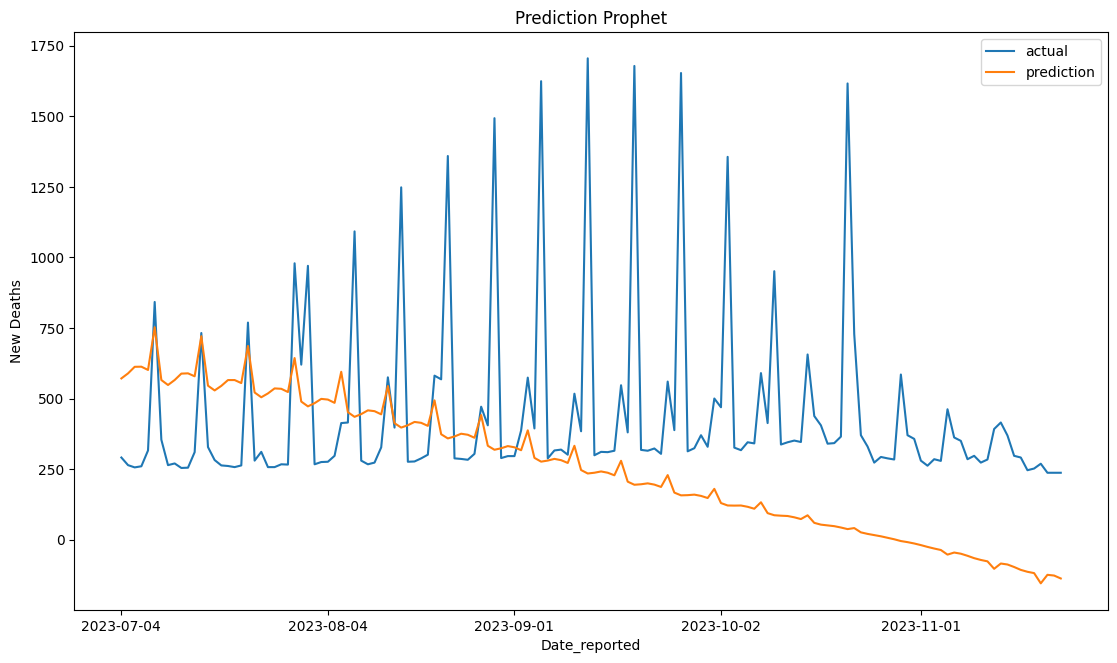

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(test['ds'], test['y'].values, label="actual")
ax.plot(test['ds'], pred['yhat'], label="prediction")
ax.set_title("Prediction Prophet")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [20]:
# Create a copy of the data
data_log = train.copy()# Create the log scale data by taking the natual log of the stock prices.
data_log['y_log'] = np.log(df['y'])
data_log = data_log.drop('y', axis=1).rename(columns={'y_log': 'y'})
data_log.head()

,ds,floor,y
0,2020-01-03,0,5.468060
1,2020-01-04,0,5.468060
2,2020-01-05,0,5.476464
3,2020-01-06,0,5.468060
4,2020-01-07,0,5.468060


In [25]:
best_params

{'changepoint_prior_scale': 0.5,
 'seasonality_prior_scale': 0.01,
 'seasonality_mode': 'additive'}

In [21]:
# Parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1.0, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the MAPEs for each params here# Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params).fit(data_log)
    # Cross-validation
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    print(df_p)
    mapes.append(df_p['smape'].values[0])# Tuning results
best_params = all_params[np.argmin(mapes)]# Best parameters
print(best_params)# Train model using best parameters
auto_model_log = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                     seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                     seasonality_mode=best_params['seasonality_mode'])# Fit the model on the training dataset
auto_model_log.fit(data_log)# Cross validation

15:43:04 - cmdstanpy - INFO - Chain [1] start processing
15:43:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:43:04 - cmdstanpy - INFO - Chain [1] start processing
15:43:04 - cmdstanpy - INFO - Chain [1] start processing
15:43:04 - cmdstanpy - INFO - Chain [1] start processing
15:43:04 - cmdstanpy - INFO - Chain [1] start processing
15:43:04 - cmdstanpy - INFO - Chain [1] done processing
15:43:04 - cmdstanpy - INFO - Chain [1] start processing
15:43:05 - cmdstanpy - INFO - Chain [1] start processing
15:43:04 - cmdstanpy - INFO - Chain [1] start processing
15:43:04 - cmdstanpy - INFO - Chain [1] done processing
15:43:05 - cmdstanpy - INFO - Chain [1] start processing
15:43:05 - cmdstanpy - INFO - Chain [1] start processing
15:43:05 - cmdstanpy - INFO - Chain [1] done processing
15:43:05 - cmdstanpy - INFO - Chain [1] start processing
15:43:05 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae     mape     mdape     smape  coverage
0 30 days  2.573217  1.604125  1.445705  0.18498  0.190397  0.165839  0.201111


15:43:11 - cmdstanpy - INFO - Chain [1] start processing
15:43:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:43:12 - cmdstanpy - INFO - Chain [1] start processing
15:43:12 - cmdstanpy - INFO - Chain [1] start processing
15:43:12 - cmdstanpy - INFO - Chain [1] start processing
15:43:12 - cmdstanpy - INFO - Chain [1] start processing
15:43:12 - cmdstanpy - INFO - Chain [1] start processing
15:43:13 - cmdstanpy - INFO - Chain [1] start processing
15:43:13 - cmdstanpy - INFO - Chain [1] start processing
15:43:13 - cmdstanpy - INFO - Chain [1] start processing
15:43:13 - cmdstanpy - INFO - Chain [1] start processing
15:43:13 - cmdstanpy - INFO - Chain [1] start processing
15:43:13 - cmdstanpy - INFO - Chain [1] start processing
15:43:13 - cmdstanpy - INFO - Chain [1] done processing
15:43:13 - cmdstanpy - INFO - Chain [1] done processing
15:43:13 - cmdstanpy - INFO - Chain [1] done

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  2.936685  1.713676  1.506128  0.191745  0.195494  0.170799   

   coverage  
0  0.217778  


15:43:20 - cmdstanpy - INFO - Chain [1] start processing
15:43:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:43:21 - cmdstanpy - INFO - Chain [1] start processing
15:43:21 - cmdstanpy - INFO - Chain [1] start processing
15:43:21 - cmdstanpy - INFO - Chain [1] start processing
15:43:21 - cmdstanpy - INFO - Chain [1] done processing
15:43:21 - cmdstanpy - INFO - Chain [1] start processing
15:43:21 - cmdstanpy - INFO - Chain [1] start processing
15:43:21 - cmdstanpy - INFO - Chain [1] start processing
15:43:21 - cmdstanpy - INFO - Chain [1] start processing
15:43:21 - cmdstanpy - INFO - Chain [1] start processing
15:43:21 - cmdstanpy - INFO - Chain [1] start processing
15:43:21 - cmdstanpy - INFO - Chain [1] done processing
15:43:21 - cmdstanpy - INFO - Chain [1] done processing
15:43:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
15:43:

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  2.740265  1.655375  1.485854  0.190373  0.191584  0.170017   

   coverage  
0  0.205556  


15:43:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:43:30 - cmdstanpy - INFO - Chain [1] start processing
15:43:30 - cmdstanpy - INFO - Chain [1] start processing
15:43:30 - cmdstanpy - INFO - Chain [1] done processing
15:43:30 - cmdstanpy - INFO - Chain [1] start processing
15:43:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
15:43:30 - cmdstanpy - INFO - Chain [1] start processing
Optimization terminated abnormally. Falling back to Newton.
15:43:30 - cmdstanpy - INFO - Chain [1] start processing
15:43:30 - cmdstanpy - INFO - Chain [1] start processing
15:43:30 - cmdstanpy - INFO - Chain [1] start processing
15:43:30 - cmdstanpy - INFO - Chain [1] start processing
15:43:30 - cmdstanpy - INFO - Chain [1] start processing
15:43:30 - cmdstanpy - INFO - Chain [1] start processing
15:43:30 - cmdstanpy - INFO - Chain [1] done processing
15

  horizon       mse     rmse       mae      mape     mdape     smape  coverage
0 30 days  3.283273  1.81198  1.585868  0.201327  0.201503  0.178328  0.234444


15:43:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:43:37 - cmdstanpy - INFO - Chain [1] start processing
15:43:38 - cmdstanpy - INFO - Chain [1] done processing
15:43:38 - cmdstanpy - INFO - Chain [1] start processing
15:43:38 - cmdstanpy - INFO - Chain [1] start processing
15:43:38 - cmdstanpy - INFO - Chain [1] start processing
15:43:38 - cmdstanpy - INFO - Chain [1] start processing
15:43:38 - cmdstanpy - INFO - Chain [1] start processing
15:43:38 - cmdstanpy - INFO - Chain [1] done processing
15:43:38 - cmdstanpy - INFO - Chain [1] done processing
15:43:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:43:38 - cmdstanpy - INFO - Chain [1] start processing
15:43:38 - cmdstanpy - INFO - Chain [1] start processing
15:43:38 - cmdstanpy - INFO - Chain [1] done processing
15:4

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  2.767084  1.663455  1.494788  0.191074  0.196522  0.170695   

   coverage  
0  0.202222  


15:43:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:43:46 - cmdstanpy - INFO - Chain [1] start processing
15:43:46 - cmdstanpy - INFO - Chain [1] start processing
15:43:46 - cmdstanpy - INFO - Chain [1] done processing
15:43:46 - cmdstanpy - INFO - Chain [1] start processing
15:43:46 - cmdstanpy - INFO - Chain [1] done processing
15:43:46 - cmdstanpy - INFO - Chain [1] start processing
15:43:46 - cmdstanpy - INFO - Chain [1] start processing
15:43:46 - cmdstanpy - INFO - Chain [1] done processing
15:43:46 - cmdstanpy - INFO - Chain [1] start processing
15:43:46 - cmdstanpy - INFO - Chain [1] done processing
15:43:46 - cmdstanpy - INFO - Chain [1] start processing
15:43:46 - cmdstanpy - INFO - Chain [1] start processing
15:43:46 - cmdstanpy - INFO - Chain [1] start processing
15:43:46 - cmdstanpy - INFO - Chain [1] start processing
15:43:46 - cmdstanpy - INFO - Chain [1] start 

  horizon       mse    rmse       mae      mape     mdape     smape  coverage
0 30 days  3.327705  1.8242  1.596235  0.202145  0.209448  0.179028      0.22


15:43:53 - cmdstanpy - INFO - Chain [1] start processing
15:43:53 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:43:54 - cmdstanpy - INFO - Chain [1] start processing
15:43:54 - cmdstanpy - INFO - Chain [1] start processing
15:43:54 - cmdstanpy - INFO - Chain [1] start processing
15:43:54 - cmdstanpy - INFO - Chain [1] start processing
15:43:54 - cmdstanpy - INFO - Chain [1] start processing
15:43:54 - cmdstanpy - INFO - Chain [1] done processing
15:43:54 - cmdstanpy - INFO - Chain [1] start processing
15:43:54 - cmdstanpy - INFO - Chain [1] done processing
15:43:54 - cmdstanpy - INFO - Chain [1] done processing
15:43:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:43:54 - cmdstanpy - INFO - Chain [1] start processing
15:43:54 - cmdstanpy - INFO - Chain [1] start processing
15:

  horizon       mse      rmse       mae     mape    mdape     smape  coverage
0 30 days  2.708367  1.645712  1.473793  0.18881  0.19058  0.168712  0.207778


15:44:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:44:02 - cmdstanpy - INFO - Chain [1] start processing
15:44:02 - cmdstanpy - INFO - Chain [1] done processing
15:44:03 - cmdstanpy - INFO - Chain [1] start processing
15:44:03 - cmdstanpy - INFO - Chain [1] start processing
15:44:03 - cmdstanpy - INFO - Chain [1] done processing
15:44:03 - cmdstanpy - INFO - Chain [1] start processing
15:44:03 - cmdstanpy - INFO - Chain [1] done processing
15:44:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
15:44:03 - cmdstanpy - INFO - Chain [1] start processing
15:44:03 - cmdstanpy - INFO - Chain [1] start processing
15:44:03 - cmdstanpy - INFO - Chain [1] start processing
15:44:03 - cmdstanpy - INFO - Chain [1] start processing
Optimization terminated abnormally. Falling back to Newton.
15:44:03 - cmdstanpy - INFO - Chain [1] start processing
15:

  horizon       mse      rmse       mae      mape    mdape     smape  coverage
0 30 days  3.269649  1.808217  1.587341  0.200774  0.20823  0.178127  0.231111


15:44:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:44:09 - cmdstanpy - INFO - Chain [1] start processing
15:44:09 - cmdstanpy - INFO - Chain [1] done processing
15:44:09 - cmdstanpy - INFO - Chain [1] start processing
15:44:09 - cmdstanpy - INFO - Chain [1] start processing
15:44:09 - cmdstanpy - INFO - Chain [1] start processing
15:44:09 - cmdstanpy - INFO - Chain [1] start processing
15:44:09 - cmdstanpy - INFO - Chain [1] start processing
15:44:09 - cmdstanpy - INFO - Chain [1] start processing
15:44:09 - cmdstanpy - INFO - Chain [1] done processing
15:44:09 - cmdstanpy - INFO - Chain [1] done processing
15:44:09 - cmdstanpy - INFO - Chain [1] done processing
15:44:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
15:44:09 - cmdstanpy - INFO - Chain [1] start processing
Optimization terminated abnormally. Falling back to Newton.
15:4

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  2.705124  1.644726  1.473013  0.188334  0.194825  0.168396   

   coverage  
0  0.211111  


15:44:18 - cmdstanpy - INFO - Chain [1] start processing
15:44:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:44:19 - cmdstanpy - INFO - Chain [1] start processing
15:44:19 - cmdstanpy - INFO - Chain [1] start processing
15:44:19 - cmdstanpy - INFO - Chain [1] done processing
15:44:19 - cmdstanpy - INFO - Chain [1] start processing
15:44:19 - cmdstanpy - INFO - Chain [1] start processing
15:44:19 - cmdstanpy - INFO - Chain [1] done processing
15:44:19 - cmdstanpy - INFO - Chain [1] start processing
15:44:19 - cmdstanpy - INFO - Chain [1] start processing
15:44:19 - cmdstanpy - INFO - Chain [1] done processing
15:44:19 - cmdstanpy - INFO - Chain [1] start processing
15:44:19 - cmdstanpy - INFO - Chain [1] done processing
15:44:19 - cmdstanpy - INFO - Chain [1] done processing
15:44:19 - cmdstanpy - INFO - Chain [1] start processing
15:44:19 - cmdstanpy - INFO - Chain [1] start p

  horizon      mse      rmse       mae      mape     mdape     smape  coverage
0 30 days  3.28179  1.811571  1.589621  0.201396  0.203495  0.178531  0.224444


15:44:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:44:24 - cmdstanpy - INFO - Chain [1] start processing
15:44:24 - cmdstanpy - INFO - Chain [1] start processing
15:44:24 - cmdstanpy - INFO - Chain [1] start processing
15:44:25 - cmdstanpy - INFO - Chain [1] start processing
15:44:25 - cmdstanpy - INFO - Chain [1] start processing
15:44:25 - cmdstanpy - INFO - Chain [1] done processing
15:44:25 - cmdstanpy - INFO - Chain [1] start processing
15:44:25 - cmdstanpy - INFO - Chain [1] done processing
15:44:25 - cmdstanpy - INFO - Chain [1] done processing
15:44:25 - cmdstanpy - INFO - Chain [1] start processing
15:44:25 - cmdstanpy - INFO - Chain [1] start processing
15:44:25 - cmdstanpy - INFO - Chain [1] start processing
15:44:25 - cmdstanpy - INFO - Chain [1] start processing
15:44:25 - cmdstanpy - INFO - Chain [1] start processing
15:44:25 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse      mae      mape     mdape     smape  coverage
0 30 days  0.364087  0.603396  0.44541  0.056261  0.040117  0.055076  0.442222


15:44:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:44:28 - cmdstanpy - INFO - Chain [1] start processing
15:44:28 - cmdstanpy - INFO - Chain [1] start processing
15:44:28 - cmdstanpy - INFO - Chain [1] start processing
15:44:28 - cmdstanpy - INFO - Chain [1] start processing
15:44:28 - cmdstanpy - INFO - Chain [1] done processing
15:44:28 - cmdstanpy - INFO - Chain [1] done processing
15:44:28 - cmdstanpy - INFO - Chain [1] start processing
15:44:28 - cmdstanpy - INFO - Chain [1] start processing
15:44:28 - cmdstanpy - INFO - Chain [1] start processing
15:44:28 - cmdstanpy - INFO - Chain [1] start processing
15:44:28 - cmdstanpy - INFO - Chain [1] start processing
15:44:28 - cmdstanpy - INFO - Chain [1] start processing
15:44:28 - cmdstanpy - INFO - Chain [1] start processing
15:44:28 - cmdstanpy - INFO - Chain [1] start processing
15:44:28 - cmdstanpy - INFO - Chain [1] done

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.438156  0.661934  0.488023  0.061506  0.043281  0.060158   

   coverage  
0  0.386667  


15:44:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:44:32 - cmdstanpy - INFO - Chain [1] start processing
15:44:32 - cmdstanpy - INFO - Chain [1] start processing
15:44:32 - cmdstanpy - INFO - Chain [1] start processing
15:44:32 - cmdstanpy - INFO - Chain [1] start processing
15:44:32 - cmdstanpy - INFO - Chain [1] done processing
15:44:32 - cmdstanpy - INFO - Chain [1] start processing
15:44:32 - cmdstanpy - INFO - Chain [1] start processing
15:44:32 - cmdstanpy - INFO - Chain [1] done processing
15:44:32 - cmdstanpy - INFO - Chain [1] start processing
15:44:32 - cmdstanpy - INFO - Chain [1] start processing
15:44:32 - cmdstanpy - INFO - Chain [1] start processing
15:44:32 - cmdstanpy - INFO - Chain [1] start processing
15:44:32 - cmdstanpy - INFO - Chain [1] done processing
15:44:32 - cmdstanpy - INFO - Chain [1] start processing
15:44:32 - cmdstanpy - INFO - Chain [1] done 

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.429115  0.655069  0.474501  0.059408  0.040405  0.058226   

   coverage  
0  0.425556  


15:44:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:44:36 - cmdstanpy - INFO - Chain [1] start processing
15:44:36 - cmdstanpy - INFO - Chain [1] start processing
15:44:36 - cmdstanpy - INFO - Chain [1] start processing
15:44:36 - cmdstanpy - INFO - Chain [1] start processing
15:44:36 - cmdstanpy - INFO - Chain [1] start processing
15:44:36 - cmdstanpy - INFO - Chain [1] done processing
15:44:36 - cmdstanpy - INFO - Chain [1] start processing
15:44:36 - cmdstanpy - INFO - Chain [1] start processing
15:44:36 - cmdstanpy - INFO - Chain [1] start processing
15:44:36 - cmdstanpy - INFO - Chain [1] start processing
15:44:36 - cmdstanpy - INFO - Chain [1] start processing
15:44:36 - cmdstanpy - INFO - Chain [1] start processing
15:44:36 - cmdstanpy - INFO - Chain [1] start processing
15:44:36 - cmdstanpy - INFO - Chain [1] done processing
15:44:36 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.569076  0.754371  0.519415  0.064781  0.045294  0.063254   

   coverage  
0  0.407778  


15:44:40 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:44:41 - cmdstanpy - INFO - Chain [1] start processing
15:44:41 - cmdstanpy - INFO - Chain [1] start processing
15:44:41 - cmdstanpy - INFO - Chain [1] start processing
15:44:41 - cmdstanpy - INFO - Chain [1] start processing
15:44:41 - cmdstanpy - INFO - Chain [1] start processing
15:44:41 - cmdstanpy - INFO - Chain [1] start processing
15:44:41 - cmdstanpy - INFO - Chain [1] start processing
15:44:41 - cmdstanpy - INFO - Chain [1] done processing
15:44:41 - cmdstanpy - INFO - Chain [1] start processing
15:44:41 - cmdstanpy - INFO - Chain [1] done processing
15:44:41 - cmdstanpy - INFO - Chain [1] start processing
15:44:41 - cmdstanpy - INFO - Chain [1] start processing
15:44:41 - cmdstanpy - INFO - Chain [1] start processing
15:44:41 - cmdstanpy - INFO - Chain [1] start processing
15:44:41 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape    mdape     smape  coverage
0 30 days  0.430726  0.656297  0.478596  0.059924  0.04182  0.058698  0.411111


15:44:44 - cmdstanpy - INFO - Chain [1] start processing
15:44:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:44:45 - cmdstanpy - INFO - Chain [1] start processing
15:44:45 - cmdstanpy - INFO - Chain [1] start processing
15:44:45 - cmdstanpy - INFO - Chain [1] start processing
15:44:45 - cmdstanpy - INFO - Chain [1] done processing
15:44:45 - cmdstanpy - INFO - Chain [1] start processing
15:44:46 - cmdstanpy - INFO - Chain [1] start processing
15:44:46 - cmdstanpy - INFO - Chain [1] start processing
15:44:46 - cmdstanpy - INFO - Chain [1] start processing
15:44:46 - cmdstanpy - INFO - Chain [1] start processing
15:44:46 - cmdstanpy - INFO - Chain [1] start processing
15:44:46 - cmdstanpy - INFO - Chain [1] start processing
15:44:46 - cmdstanpy - INFO - Chain [1] start processing
15:44:46 - cmdstanpy - INFO - Chain [1] start processing
15:44:46 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.569576  0.754703  0.517377  0.064579  0.044181  0.063135   

   coverage  
0  0.417778  


15:44:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:44:50 - cmdstanpy - INFO - Chain [1] start processing
15:44:50 - cmdstanpy - INFO - Chain [1] done processing
15:44:50 - cmdstanpy - INFO - Chain [1] start processing
15:44:50 - cmdstanpy - INFO - Chain [1] start processing
15:44:50 - cmdstanpy - INFO - Chain [1] start processing
15:44:50 - cmdstanpy - INFO - Chain [1] start processing
15:44:50 - cmdstanpy - INFO - Chain [1] start processing
15:44:50 - cmdstanpy - INFO - Chain [1] start processing
15:44:50 - cmdstanpy - INFO - Chain [1] start processing
15:44:50 - cmdstanpy - INFO - Chain [1] start processing
15:44:50 - cmdstanpy - INFO - Chain [1] start processing
15:44:50 - cmdstanpy - INFO - Chain [1] start processing
15:44:50 - cmdstanpy - INFO - Chain [1] start processing
15:44:50 - cmdstanpy - INFO - Chain [1] start processing
15:44:50 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse      mae      mape     mdape     smape  coverage
0 30 days  0.429758  0.655559  0.48295  0.060359  0.044546  0.059211  0.406667


15:44:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:44:54 - cmdstanpy - INFO - Chain [1] start processing
15:44:54 - cmdstanpy - INFO - Chain [1] start processing
15:44:54 - cmdstanpy - INFO - Chain [1] start processing
15:44:54 - cmdstanpy - INFO - Chain [1] start processing
15:44:54 - cmdstanpy - INFO - Chain [1] start processing
15:44:54 - cmdstanpy - INFO - Chain [1] done processing
15:44:54 - cmdstanpy - INFO - Chain [1] start processing
15:44:54 - cmdstanpy - INFO - Chain [1] start processing
15:44:54 - cmdstanpy - INFO - Chain [1] start processing
15:44:54 - cmdstanpy - INFO - Chain [1] start processing
15:44:54 - cmdstanpy - INFO - Chain [1] start processing
15:44:55 - cmdstanpy - INFO - Chain [1] start processing
15:44:55 - cmdstanpy - INFO - Chain [1] start processing
15:44:55 - cmdstanpy - INFO - Chain [1] start processing
15:44:55 - cmdstanpy - INFO - Chain [1] don

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.579589  0.761308  0.522788  0.065154  0.044336  0.063682   

   coverage  
0  0.403333  


15:44:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:44:59 - cmdstanpy - INFO - Chain [1] start processing
15:44:59 - cmdstanpy - INFO - Chain [1] start processing
15:44:59 - cmdstanpy - INFO - Chain [1] done processing
15:44:59 - cmdstanpy - INFO - Chain [1] start processing
15:44:59 - cmdstanpy - INFO - Chain [1] done processing
15:44:59 - cmdstanpy - INFO - Chain [1] start processing
15:44:59 - cmdstanpy - INFO - Chain [1] start processing
15:44:59 - cmdstanpy - INFO - Chain [1] start processing
15:44:59 - cmdstanpy - INFO - Chain [1] start processing
15:44:59 - cmdstanpy - INFO - Chain [1] start processing
15:44:59 - cmdstanpy - INFO - Chain [1] done processing
15:44:59 - cmdstanpy - INFO - Chain [1] start processing
15:44:59 - cmdstanpy - INFO - Chain [1] start processing
15:44:59 - cmdstanpy - INFO - Chain [1] start processing
15:44:59 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse      mae      mape     mdape     smape  coverage
0 30 days  0.440684  0.663841  0.48686  0.060778  0.043094  0.059581  0.391111


15:45:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:45:04 - cmdstanpy - INFO - Chain [1] start processing
15:45:04 - cmdstanpy - INFO - Chain [1] start processing
15:45:04 - cmdstanpy - INFO - Chain [1] start processing
15:45:04 - cmdstanpy - INFO - Chain [1] start processing
15:45:04 - cmdstanpy - INFO - Chain [1] start processing
15:45:04 - cmdstanpy - INFO - Chain [1] done processing
15:45:04 - cmdstanpy - INFO - Chain [1] start processing
15:45:04 - cmdstanpy - INFO - Chain [1] start processing
15:45:04 - cmdstanpy - INFO - Chain [1] start processing
15:45:04 - cmdstanpy - INFO - Chain [1] start processing
15:45:04 - cmdstanpy - INFO - Chain [1] done processing
15:45:04 - cmdstanpy - INFO - Chain [1] done processing
15:45:04 - cmdstanpy - INFO - Chain [1] done processing
15:45:04 - cmdstanpy - INFO - Chain [1] start processing
15:45:04 - cmdstanpy - INFO - Chain [1] start 

  horizon       mse     rmse       mae      mape     mdape     smape  coverage
0 30 days  0.578848  0.76082  0.525655  0.065529  0.045565  0.064089  0.404444


15:45:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:45:08 - cmdstanpy - INFO - Chain [1] start processing
15:45:08 - cmdstanpy - INFO - Chain [1] start processing
15:45:08 - cmdstanpy - INFO - Chain [1] start processing
15:45:08 - cmdstanpy - INFO - Chain [1] start processing
15:45:08 - cmdstanpy - INFO - Chain [1] done processing
15:45:08 - cmdstanpy - INFO - Chain [1] start processing
15:45:08 - cmdstanpy - INFO - Chain [1] done processing
15:45:08 - cmdstanpy - INFO - Chain [1] start processing
15:45:08 - cmdstanpy - INFO - Chain [1] start processing
15:45:08 - cmdstanpy - INFO - Chain [1] done processing
15:45:08 - cmdstanpy - INFO - Chain [1] start processing
15:45:08 - cmdstanpy - INFO - Chain [1] start processing
15:45:08 - cmdstanpy - INFO - Chain [1] start processing
15:45:08 - cmdstanpy - INFO - Chain [1] start processing
15:45:08 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae     mape     mdape     smape  coverage
0 30 days  0.338204  0.581553  0.424162  0.05334  0.037126  0.052362  0.446667


15:45:12 - cmdstanpy - INFO - Chain [1] start processing
15:45:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:45:13 - cmdstanpy - INFO - Chain [1] start processing
15:45:13 - cmdstanpy - INFO - Chain [1] start processing
15:45:13 - cmdstanpy - INFO - Chain [1] start processing
15:45:13 - cmdstanpy - INFO - Chain [1] done processing
15:45:13 - cmdstanpy - INFO - Chain [1] start processing
15:45:13 - cmdstanpy - INFO - Chain [1] start processing
15:45:13 - cmdstanpy - INFO - Chain [1] start processing
15:45:13 - cmdstanpy - INFO - Chain [1] start processing
15:45:13 - cmdstanpy - INFO - Chain [1] start processing
15:45:13 - cmdstanpy - INFO - Chain [1] start processing
15:45:13 - cmdstanpy - INFO - Chain [1] done processing
15:45:13 - cmdstanpy - INFO - Chain [1] start processing
15:45:13 - cmdstanpy - INFO - Chain [1] start processing
15:45:13 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.360013  0.600011  0.437415  0.055375  0.037725  0.054129   

   coverage  
0  0.411111  


15:45:17 - cmdstanpy - INFO - Chain [1] start processing
15:45:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:45:18 - cmdstanpy - INFO - Chain [1] start processing
15:45:18 - cmdstanpy - INFO - Chain [1] start processing
15:45:18 - cmdstanpy - INFO - Chain [1] done processing
15:45:18 - cmdstanpy - INFO - Chain [1] start processing
15:45:18 - cmdstanpy - INFO - Chain [1] done processing
15:45:18 - cmdstanpy - INFO - Chain [1] start processing
15:45:18 - cmdstanpy - INFO - Chain [1] start processing
15:45:18 - cmdstanpy - INFO - Chain [1] start processing
15:45:18 - cmdstanpy - INFO - Chain [1] done processing
15:45:18 - cmdstanpy - INFO - Chain [1] start processing
15:45:18 - cmdstanpy - INFO - Chain [1] start processing
15:45:18 - cmdstanpy - INFO - Chain [1] start processing
15:45:18 - cmdstanpy - INFO - Chain [1] start processing
15:45:18 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.418795  0.647144  0.458036  0.057175  0.038601  0.056332   

   coverage  
0  0.432222  


15:45:22 - cmdstanpy - INFO - Chain [1] start processing
15:45:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:45:23 - cmdstanpy - INFO - Chain [1] start processing
15:45:23 - cmdstanpy - INFO - Chain [1] start processing
15:45:23 - cmdstanpy - INFO - Chain [1] start processing
15:45:23 - cmdstanpy - INFO - Chain [1] start processing
15:45:23 - cmdstanpy - INFO - Chain [1] done processing
15:45:23 - cmdstanpy - INFO - Chain [1] start processing
15:45:23 - cmdstanpy - INFO - Chain [1] start processing
15:45:23 - cmdstanpy - INFO - Chain [1] start processing
15:45:23 - cmdstanpy - INFO - Chain [1] start processing
15:45:23 - cmdstanpy - INFO - Chain [1] start processing
15:45:23 - cmdstanpy - INFO - Chain [1] start processing
15:45:23 - cmdstanpy - INFO - Chain [1] start processing
15:45:24 - cmdstanpy - INFO - Chain [1] start processing
15:45:24 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape    mdape     smape  coverage
0 30 days  0.530921  0.728643  0.496571  0.062099  0.04236  0.060521  0.411111


15:45:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:45:29 - cmdstanpy - INFO - Chain [1] start processing
15:45:29 - cmdstanpy - INFO - Chain [1] start processing
15:45:29 - cmdstanpy - INFO - Chain [1] start processing
15:45:29 - cmdstanpy - INFO - Chain [1] start processing
15:45:29 - cmdstanpy - INFO - Chain [1] start processing
15:45:29 - cmdstanpy - INFO - Chain [1] start processing
15:45:29 - cmdstanpy - INFO - Chain [1] start processing
15:45:29 - cmdstanpy - INFO - Chain [1] start processing
15:45:29 - cmdstanpy - INFO - Chain [1] start processing
15:45:29 - cmdstanpy - INFO - Chain [1] done processing
15:45:29 - cmdstanpy - INFO - Chain [1] start processing
15:45:29 - cmdstanpy - INFO - Chain [1] start processing
15:45:29 - cmdstanpy - INFO - Chain [1] start processing
15:45:29 - cmdstanpy - INFO - Chain [1] done processing
15:45:29 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae     mape     mdape     smape  coverage
0 30 days  0.416392  0.645285  0.465298  0.05808  0.040966  0.057284  0.406667


15:45:33 - cmdstanpy - INFO - Chain [1] start processing
15:45:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:45:34 - cmdstanpy - INFO - Chain [1] start processing
15:45:34 - cmdstanpy - INFO - Chain [1] start processing
15:45:34 - cmdstanpy - INFO - Chain [1] start processing
15:45:34 - cmdstanpy - INFO - Chain [1] start processing
15:45:34 - cmdstanpy - INFO - Chain [1] start processing
15:45:35 - cmdstanpy - INFO - Chain [1] start processing
15:45:35 - cmdstanpy - INFO - Chain [1] done processing
15:45:35 - cmdstanpy - INFO - Chain [1] start processing
15:45:35 - cmdstanpy - INFO - Chain [1] start processing
15:45:35 - cmdstanpy - INFO - Chain [1] start processing
15:45:35 - cmdstanpy - INFO - Chain [1] start processing
15:45:35 - cmdstanpy - INFO - Chain [1] done processing
15:45:35 - cmdstanpy - INFO - Chain [1] start processing
15:45:35 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.536968  0.732781  0.498075  0.062287  0.042375  0.060759   

   coverage  
0  0.404444  


15:45:38 - cmdstanpy - INFO - Chain [1] start processing
15:45:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:45:39 - cmdstanpy - INFO - Chain [1] start processing
15:45:39 - cmdstanpy - INFO - Chain [1] done processing
15:45:39 - cmdstanpy - INFO - Chain [1] start processing
15:45:39 - cmdstanpy - INFO - Chain [1] start processing
15:45:39 - cmdstanpy - INFO - Chain [1] start processing
15:45:39 - cmdstanpy - INFO - Chain [1] start processing
15:45:39 - cmdstanpy - INFO - Chain [1] start processing
15:45:39 - cmdstanpy - INFO - Chain [1] start processing
15:45:40 - cmdstanpy - INFO - Chain [1] start processing
15:45:40 - cmdstanpy - INFO - Chain [1] start processing
15:45:40 - cmdstanpy - INFO - Chain [1] done processing
15:45:40 - cmdstanpy - INFO - Chain [1] done processing
15:45:40 - cmdstanpy - INFO - Chain [1] start processing
15:45:40 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse       mae      mape     mdape   smape  coverage
0 30 days  0.421135  0.648949  0.460932  0.057547  0.039498  0.0567  0.423333


15:45:43 - cmdstanpy - INFO - Chain [1] start processing
15:45:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:45:44 - cmdstanpy - INFO - Chain [1] start processing
15:45:44 - cmdstanpy - INFO - Chain [1] start processing
15:45:44 - cmdstanpy - INFO - Chain [1] done processing
15:45:44 - cmdstanpy - INFO - Chain [1] start processing
15:45:44 - cmdstanpy - INFO - Chain [1] start processing
15:45:44 - cmdstanpy - INFO - Chain [1] start processing
15:45:44 - cmdstanpy - INFO - Chain [1] done processing
15:45:44 - cmdstanpy - INFO - Chain [1] start processing
15:45:44 - cmdstanpy - INFO - Chain [1] done processing
15:45:44 - cmdstanpy - INFO - Chain [1] start processing
15:45:44 - cmdstanpy - INFO - Chain [1] start processing
15:45:44 - cmdstanpy - INFO - Chain [1] start processing
15:45:44 - cmdstanpy - INFO - Chain [1] start processing
15:45:44 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse      mae      mape     mdape     smape  coverage
0 30 days  0.528193  0.726769  0.49332  0.061677  0.041475  0.060158      0.42


15:45:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:45:49 - cmdstanpy - INFO - Chain [1] start processing
15:45:49 - cmdstanpy - INFO - Chain [1] start processing
15:45:49 - cmdstanpy - INFO - Chain [1] done processing
15:45:49 - cmdstanpy - INFO - Chain [1] start processing
15:45:49 - cmdstanpy - INFO - Chain [1] start processing
15:45:49 - cmdstanpy - INFO - Chain [1] start processing
15:45:49 - cmdstanpy - INFO - Chain [1] start processing
15:45:49 - cmdstanpy - INFO - Chain [1] start processing
15:45:49 - cmdstanpy - INFO - Chain [1] start processing
15:45:49 - cmdstanpy - INFO - Chain [1] start processing
15:45:49 - cmdstanpy - INFO - Chain [1] start processing
15:45:49 - cmdstanpy - INFO - Chain [1] done processing
15:45:49 - cmdstanpy - INFO - Chain [1] start processing
15:45:49 - cmdstanpy - INFO - Chain [1] start processing
15:45:49 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse      mae      mape     mdape     smape  coverage
0 30 days  0.403919  0.635546  0.45432  0.056726  0.039231  0.055932  0.424444


15:45:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:45:52 - cmdstanpy - INFO - Chain [1] start processing
15:45:52 - cmdstanpy - INFO - Chain [1] start processing
15:45:52 - cmdstanpy - INFO - Chain [1] start processing
15:45:52 - cmdstanpy - INFO - Chain [1] start processing
15:45:52 - cmdstanpy - INFO - Chain [1] done processing
15:45:53 - cmdstanpy - INFO - Chain [1] start processing
15:45:53 - cmdstanpy - INFO - Chain [1] start processing
15:45:53 - cmdstanpy - INFO - Chain [1] done processing
15:45:53 - cmdstanpy - INFO - Chain [1] start processing
15:45:53 - cmdstanpy - INFO - Chain [1] done processing
15:45:53 - cmdstanpy - INFO - Chain [1] start processing
15:45:53 - cmdstanpy - INFO - Chain [1] start processing
15:45:53 - cmdstanpy - INFO - Chain [1] start processing
15:45:53 - cmdstanpy - INFO - Chain [1] start processing
15:45:53 - cmdstanpy - INFO - Chain [1] start

  horizon       mse      rmse      mae      mape     mdape     smape  coverage
0 30 days  0.518605  0.720143  0.49082  0.061383  0.041424  0.059765  0.404444


15:45:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:45:57 - cmdstanpy - INFO - Chain [1] start processing
15:45:57 - cmdstanpy - INFO - Chain [1] start processing
15:45:57 - cmdstanpy - INFO - Chain [1] start processing
15:45:57 - cmdstanpy - INFO - Chain [1] start processing
15:45:57 - cmdstanpy - INFO - Chain [1] start processing
15:45:57 - cmdstanpy - INFO - Chain [1] start processing
15:45:57 - cmdstanpy - INFO - Chain [1] start processing
15:45:57 - cmdstanpy - INFO - Chain [1] start processing
15:45:57 - cmdstanpy - INFO - Chain [1] start processing
15:45:57 - cmdstanpy - INFO - Chain [1] start processing
15:45:57 - cmdstanpy - INFO - Chain [1] start processing
15:45:58 - cmdstanpy - INFO - Chain [1] start processing
15:45:58 - cmdstanpy - INFO - Chain [1] start processing
15:45:58 - cmdstanpy - INFO - Chain [1] start processing
15:45:58 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse       mae     mape     mdape     smape  coverage
0 30 days  0.279535  0.528711  0.354232  0.04501  0.026321  0.044155  0.567778


15:46:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:46:03 - cmdstanpy - INFO - Chain [1] start processing
15:46:03 - cmdstanpy - INFO - Chain [1] start processing
15:46:03 - cmdstanpy - INFO - Chain [1] start processing
15:46:03 - cmdstanpy - INFO - Chain [1] start processing
15:46:03 - cmdstanpy - INFO - Chain [1] start processing
15:46:03 - cmdstanpy - INFO - Chain [1] start processing
15:46:03 - cmdstanpy - INFO - Chain [1] start processing
15:46:03 - cmdstanpy - INFO - Chain [1] start processing
15:46:03 - cmdstanpy - INFO - Chain [1] start processing
15:46:03 - cmdstanpy - INFO - Chain [1] start processing
15:46:03 - cmdstanpy - INFO - Chain [1] start processing
15:46:03 - cmdstanpy - INFO - Chain [1] start processing
15:46:03 - cmdstanpy - INFO - Chain [1] start processing
15:46:03 - cmdstanpy - INFO - Chain [1] start processing
15:46:03 - cmdstanpy - INFO - Chain [1] st

  horizon       mse     rmse       mae      mape     mdape     smape  coverage
0 30 days  0.279725  0.52889  0.372134  0.047657  0.033502  0.046696  0.483333


15:46:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:46:09 - cmdstanpy - INFO - Chain [1] start processing
15:46:09 - cmdstanpy - INFO - Chain [1] start processing
15:46:09 - cmdstanpy - INFO - Chain [1] done processing
15:46:09 - cmdstanpy - INFO - Chain [1] start processing
15:46:09 - cmdstanpy - INFO - Chain [1] start processing
15:46:09 - cmdstanpy - INFO - Chain [1] start processing
15:46:09 - cmdstanpy - INFO - Chain [1] start processing
15:46:09 - cmdstanpy - INFO - Chain [1] start processing
15:46:09 - cmdstanpy - INFO - Chain [1] start processing
15:46:09 - cmdstanpy - INFO - Chain [1] start processing
15:46:09 - cmdstanpy - INFO - Chain [1] start processing
15:46:09 - cmdstanpy - INFO - Chain [1] start processing
15:46:09 - cmdstanpy - INFO - Chain [1] start processing
15:46:09 - cmdstanpy - INFO - Chain [1] start processing
15:46:09 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.420733  0.648639  0.427381  0.053813  0.032654  0.052514   

   coverage  
0  0.486667  


15:46:14 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:46:15 - cmdstanpy - INFO - Chain [1] start processing
15:46:15 - cmdstanpy - INFO - Chain [1] start processing
15:46:15 - cmdstanpy - INFO - Chain [1] start processing
15:46:15 - cmdstanpy - INFO - Chain [1] start processing
15:46:15 - cmdstanpy - INFO - Chain [1] start processing
15:46:15 - cmdstanpy - INFO - Chain [1] start processing
15:46:15 - cmdstanpy - INFO - Chain [1] start processing
15:46:15 - cmdstanpy - INFO - Chain [1] start processing
15:46:15 - cmdstanpy - INFO - Chain [1] start processing
15:46:15 - cmdstanpy - INFO - Chain [1] start processing
15:46:15 - cmdstanpy - INFO - Chain [1] start processing
15:46:15 - cmdstanpy - INFO - Chain [1] start processing
15:46:15 - cmdstanpy - INFO - Chain [1] start processing
15:46:15 - cmdstanpy - INFO - Chain [1] start processing
15:46:15 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse       mae     mape    mdape  smape  coverage
0 30 days  0.741214  0.860938  0.582879  0.07162  0.04851   0.07  0.381111


15:46:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:46:21 - cmdstanpy - INFO - Chain [1] start processing
15:46:21 - cmdstanpy - INFO - Chain [1] start processing
15:46:21 - cmdstanpy - INFO - Chain [1] start processing
15:46:21 - cmdstanpy - INFO - Chain [1] start processing
15:46:21 - cmdstanpy - INFO - Chain [1] start processing
15:46:21 - cmdstanpy - INFO - Chain [1] start processing
15:46:21 - cmdstanpy - INFO - Chain [1] start processing
15:46:21 - cmdstanpy - INFO - Chain [1] done processing
15:46:22 - cmdstanpy - INFO - Chain [1] start processing
15:46:22 - cmdstanpy - INFO - Chain [1] start processing
15:46:22 - cmdstanpy - INFO - Chain [1] start processing
15:46:22 - cmdstanpy - INFO - Chain [1] start processing
15:46:22 - cmdstanpy - INFO - Chain [1] done processing
15:46:22 - cmdstanpy - INFO - Chain [1] start processing
15:46:22 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.426457  0.653037  0.430034  0.054162  0.033105  0.052817   

   coverage  
0  0.482222  


15:46:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:46:27 - cmdstanpy - INFO - Chain [1] start processing
15:46:27 - cmdstanpy - INFO - Chain [1] start processing
15:46:27 - cmdstanpy - INFO - Chain [1] start processing
15:46:27 - cmdstanpy - INFO - Chain [1] start processing
15:46:27 - cmdstanpy - INFO - Chain [1] start processing
15:46:27 - cmdstanpy - INFO - Chain [1] start processing
15:46:27 - cmdstanpy - INFO - Chain [1] start processing
15:46:27 - cmdstanpy - INFO - Chain [1] start processing
15:46:27 - cmdstanpy - INFO - Chain [1] start processing
15:46:27 - cmdstanpy - INFO - Chain [1] start processing
15:46:27 - cmdstanpy - INFO - Chain [1] start processing
15:46:27 - cmdstanpy - INFO - Chain [1] start processing
15:46:27 - cmdstanpy - INFO - Chain [1] start processing
15:46:27 - cmdstanpy - INFO - Chain [1] start processing
15:46:27 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.728417  0.853474  0.573152  0.070446  0.046334  0.068982   

   coverage  
0  0.398889  


15:46:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:46:34 - cmdstanpy - INFO - Chain [1] start processing
15:46:34 - cmdstanpy - INFO - Chain [1] start processing
15:46:34 - cmdstanpy - INFO - Chain [1] done processing
15:46:34 - cmdstanpy - INFO - Chain [1] start processing
15:46:35 - cmdstanpy - INFO - Chain [1] start processing
15:46:35 - cmdstanpy - INFO - Chain [1] start processing
15:46:35 - cmdstanpy - INFO - Chain [1] start processing
15:46:35 - cmdstanpy - INFO - Chain [1] start processing
15:46:35 - cmdstanpy - INFO - Chain [1] start processing
15:46:35 - cmdstanpy - INFO - Chain [1] start processing
15:46:35 - cmdstanpy - INFO - Chain [1] done processing
15:46:35 - cmdstanpy - INFO - Chain [1] start processing
15:46:35 - cmdstanpy - INFO - Chain [1] start processing
15:46:35 - cmdstanpy - INFO - Chain [1] start processing
15:46:35 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.428806  0.654832  0.430257  0.054144  0.032679  0.052821   

   coverage  
0  0.485556  


15:46:40 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:46:41 - cmdstanpy - INFO - Chain [1] start processing
15:46:41 - cmdstanpy - INFO - Chain [1] start processing
15:46:41 - cmdstanpy - INFO - Chain [1] start processing
15:46:41 - cmdstanpy - INFO - Chain [1] start processing
15:46:41 - cmdstanpy - INFO - Chain [1] start processing
15:46:41 - cmdstanpy - INFO - Chain [1] start processing
15:46:41 - cmdstanpy - INFO - Chain [1] start processing
15:46:41 - cmdstanpy - INFO - Chain [1] start processing
15:46:41 - cmdstanpy - INFO - Chain [1] start processing
15:46:41 - cmdstanpy - INFO - Chain [1] start processing
15:46:41 - cmdstanpy - INFO - Chain [1] start processing
15:46:41 - cmdstanpy - INFO - Chain [1] start processing
15:46:41 - cmdstanpy - INFO - Chain [1] done processing
15:46:41 - cmdstanpy - INFO - Chain [1] start processing
15:46:41 - cmdstanpy - INFO - Chain [1] sta

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.740612  0.860588  0.573367  0.070483  0.045604  0.068742   

   coverage  
0  0.397778  


15:46:46 - cmdstanpy - INFO - Chain [1] start processing
15:46:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:46:47 - cmdstanpy - INFO - Chain [1] start processing
15:46:47 - cmdstanpy - INFO - Chain [1] start processing
15:46:47 - cmdstanpy - INFO - Chain [1] start processing
15:46:47 - cmdstanpy - INFO - Chain [1] done processing
15:46:47 - cmdstanpy - INFO - Chain [1] start processing
15:46:47 - cmdstanpy - INFO - Chain [1] start processing
15:46:47 - cmdstanpy - INFO - Chain [1] done processing
15:46:47 - cmdstanpy - INFO - Chain [1] start processing
15:46:47 - cmdstanpy - INFO - Chain [1] start processing
15:46:47 - cmdstanpy - INFO - Chain [1] start processing
15:46:47 - cmdstanpy - INFO - Chain [1] start processing
15:46:47 - cmdstanpy - INFO - Chain [1] start processing
15:46:47 - cmdstanpy - INFO - Chain [1] start processing
15:46:47 - cmdstanpy - INFO - Chain [1] star

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.429566  0.655413  0.431689  0.054347  0.032837  0.053052   

   coverage  
0  0.485556  


15:46:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:46:53 - cmdstanpy - INFO - Chain [1] start processing
15:46:53 - cmdstanpy - INFO - Chain [1] start processing
15:46:53 - cmdstanpy - INFO - Chain [1] start processing
15:46:53 - cmdstanpy - INFO - Chain [1] start processing
15:46:53 - cmdstanpy - INFO - Chain [1] start processing
15:46:53 - cmdstanpy - INFO - Chain [1] start processing
15:46:53 - cmdstanpy - INFO - Chain [1] start processing
15:46:53 - cmdstanpy - INFO - Chain [1] start processing
15:46:53 - cmdstanpy - INFO - Chain [1] start processing
15:46:53 - cmdstanpy - INFO - Chain [1] start processing
15:46:53 - cmdstanpy - INFO - Chain [1] start processing
15:46:53 - cmdstanpy - INFO - Chain [1] start processing
15:46:53 - cmdstanpy - INFO - Chain [1] start processing
15:46:53 - cmdstanpy - INFO - Chain [1] start processing
15:46:53 - cmdstanpy - INFO - Chain [1] st

  horizon       mse      rmse       mae      mape     mdape     smape  \
0 30 days  0.740931  0.860774  0.573714  0.070464  0.045815  0.068792   

   coverage  
0  0.391111  
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}


15:46:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:46:58 - cmdstanpy - INFO - Chain [1] start processing
15:46:59 - cmdstanpy - INFO - Chain [1] start processing
15:46:59 - cmdstanpy - INFO - Chain [1] start processing
15:46:59 - cmdstanpy - INFO - Chain [1] start processing
15:46:59 - cmdstanpy - INFO - Chain [1] start processing
15:46:59 - cmdstanpy - INFO - Chain [1] start processing
15:46:59 - cmdstanpy - INFO - Chain [1] start processing
15:46:59 - cmdstanpy - INFO - Chain [1] start processing
15:46:59 - cmdstanpy - INFO - Chain [1] start processing
15:46:59 - cmdstanpy - INFO - Chain [1] start processing
15:46:59 - cmdstanpy - INFO - Chain [1] start processing
15:46:59 - cmdstanpy - INFO - Chain [1] start processing
15:46:59 - cmdstanpy - INFO - Chain [1] start processing
15:46:59 - cmdstanpy - INFO - Chain [1] start processing
15:46:59 - cmdstanpy - INFO - Chain [1] st

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,0.279535,0.528711,0.354232,0.04501,0.026321,0.044155,0.567778


In [22]:
pred = auto_model_log.predict(test)
pred = y_pred_original_scale = np.exp(pred['yhat'])


In [23]:
non_zero = []
for i in pred:
    if i == 0:
        non_zero.append(i+sys.float_info.min)
    else:
        non_zero.append(i)
print_evaluation_metrics(non_zero, test['y'])

Evaluation Metrics:
MSE: 126807.32
RMSE: 356.10
MAE: 181.77
MAPE: 31.92
SMAPE: 35.33


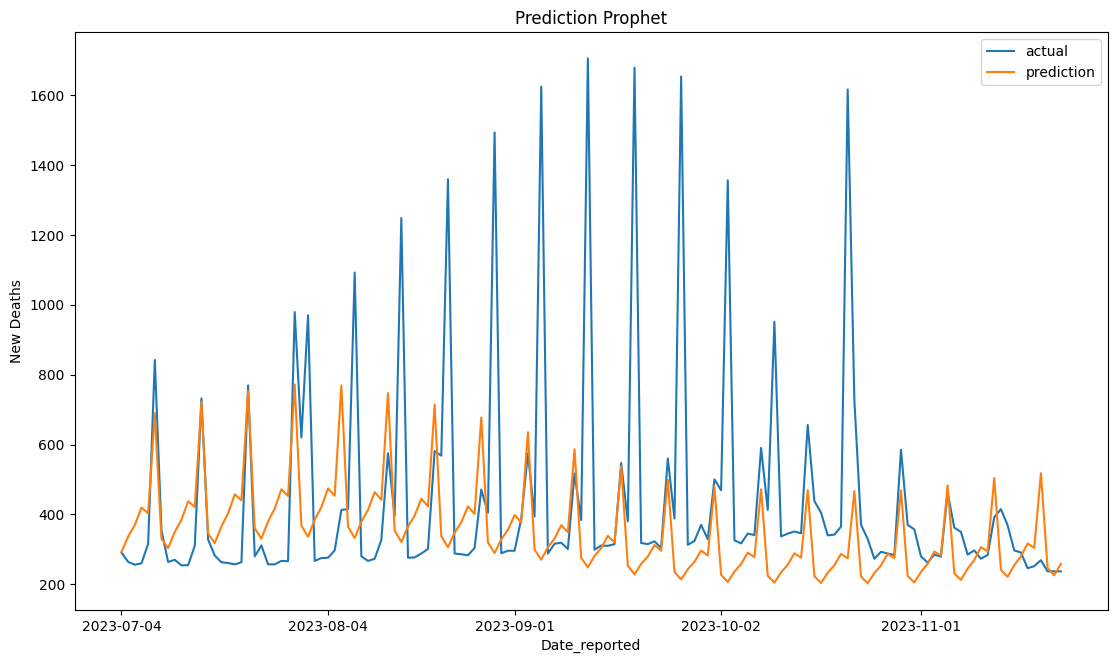

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(test['ds'], test['y'].values, label="actual")
ax.plot(test['ds'], pred, label="prediction")
ax.set_title("Prediction Prophet")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()